In [11]:
import numpy as np
import math
import random
import itertools
from itertools import *
import scipy
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
from pandas import *
import seaborn as sns
import time

from pygrnd.optimize.UCPquboFunctionLibrary import *

#import UCPquboFunctionLibrary
#from UCPquboFunctionLibrary import *

# Solving the stochastic Unit Commitment Problem \(SUCP\) with QUBO's



The unit commitment problem \(**UCP**\) in electrical power production is a mathematical optimization problem where one wants to find the best possible allocation of power supply units, e.g., to match a specific demand of energy over a number of timesteps. Here, we present a way to tackle the problem using a quadratic unconstrained binary optimization \(**QUBO**\) formulation. The goal is to model every constraint as a penalty term and add it to the objective that we want to minimize in order to solve the UCP. We require the objective to be such that we

- match the power demand

- minimize the overall costs

- consider minimum run times \(_minup_\) and minimum down times \(_mindown_\)

- consider minimum/maximum power supply \(_mingen/maxgen_\)

The optimal solution is given by the ground state (lowest energy state) of the objective. 

Additionally, we consider probability distributions that describe uncertainties in the demand and in the supply of the renewable units in the problem. This defines a stochastic version of the unit commitment problem \(SUCP\). 

Technical details about the exact mathematical formulation can be found in "Quantum Computing Approach to the (stochastic) Unit Commitment Problem".



We start with the problem specification:

#### Specify units properties and probability distributions for demand and renewable supply



Some example sets are shown below. The last cell defines the UCP instance that is solved.


In [12]:
#problem size XXS (2 units, 1 timestep)
hour=[1]
demand = [500]                                         # list containing demand elements for individual timesteps
suppren=[[25,75]]                                      # list containing supply of renewables in each timestep; number of renewables = len(suppren[0])
varcost = [50,35]                                      # list containing varcost for each unit
maxgen = [500,800]                                     # list containing maxgen for each unit
mingen = [40, 250]                                     # list containing mingen for each unit
startcost = [3000,5000]                                # list containing startcost for each unit
minup = [1,1]                                          # list containing minup for each unit
mindown = [1,1]                                        # list containing mindown for each unit

pdRE=[[[40,50,60],[80,100,120]]]                                           # renewable supply with structure: pdRE=[timestep[1],..,[timestep[T]]];
                                                                          # timestep[n]=[unit_1,..,unit_N]; unit_r=[list of possible power supply values]
probsRE=[[[0.1,0.8,0.1],[0.1,0.8,0.1]]]                                   # probabilities for corresponding power supply levels
pdD=[[700,800,900]]                                                       # demand supply possibilities in every timestep
probsD=[[0.1,0.8,0.1]]                                                    # probabilities for possible demand values in every timestep

In [13]:
#problem size XS (2 units, 3 timestep)

hour=[1,2,3]
demand = [618, 1445, 710]                             # list containing demand elements for individual timesteps
suppren=[[50,100],[50,150],[25,125]]                  # list containing supply of renewables in each timestep; number of renewables = len(suppren[0])
varcost = [65,25]                                     # list containing varcost for each unit
maxgen = [505,900]                                    # list containing maxgen for each unit
mingen = [34, 250]                                    # list containing mingen for each unit
startcost = [20000,50000]                             # list containing startcost for each unit
minup = [2,2]                                         # list containing minup for each unit
mindown = [1,2]                                       # list containing mindown for each unit

pdRE=[[[40,50,60],[80,100,120]],[[30,50,70],[120,150,180]],[[5,25,45],[80,125,170]]]                      # renewable supply with structure: pdRE=[timestep[1],..,[timestep[T]]];
                                                                                                          # timestep[n]=[unit_1,..,unit_N]; unit_r=[list of possible power supply values]
probsRE=[[[0.1,0.8,0.1],[0.1,0.8,0.1]],[[0.15,0.7,0.15],[0.15,0.7,0.15]],[[0.2,0.6,0.2],[0.2,0.6,0.2]]]   # probabilities for corresponding power supply levels
pdD=[[518,618,718],[1145,1445,1745],[310,710,1110]]                                                       # demand supply possibilities in every timestep
probsD=[[0.1,0.8,0.1],[0.15,0.7,0.15],[0.2,0.6,0.2]]                                                      # probabilities for possible demand values in every timestep

In [14]:
#problem size XXXS (2 units, 1 timestep)
hour=[1]
demand = [15]                                         # list containing demand elements for individual timesteps
suppren=[9]                                      # list containing supply of renewables in each timestep; number of renewables = len(suppren[0])
varcost = [2,10]                                      # list containing varcost for each unit
maxgen = [10,15]                                     # list containing maxgen for each unit
mingen = [0, 0]                                     # list containing mingen for each unit
startcost = [0,0]                                # list containing startcost for each unit
minup = [0,0]                                          # list containing minup for each unit
mindown = [0,0]                                        # list containing mindown for each unit

pdRE=[[5,10]]                                           # renewable supply with structure: pdRE=[timestep[1],..,[timestep[T]]];
                                                                          # timestep[n]=[unit_1,..,unit_N]; unit_r=[list of possible power supply values]
probsRE=[[0.2,0.8]]                                   # probabilities for corresponding power supply levels
pdD=[[15]]                                                       # demand supply possibilities in every timestep
probsD=[[1]]                                                    # probabilities for possible demand values in every timestep

In [15]:
#problem size S (2 units, 5 timestep)

hour=[1,2,3,4,5]
demand = [618, 1445, 710, 710, 1255]                             # list containing demand elements for individual timesteps
suppren=[[50,100],[50,150],[25,125],[25,50],[35,15]]             # list containing supply of renewables in each timestep; number of renewables = len(suppren[0])
varcost = [65,25]                                                # list containing varcost for each unit
maxgen = [505,900]                                               # list containing maxgen for each unit
mingen = [34, 250]                                               # list containing mingen for each unit
startcost = [20000,50000]                                        # list containing startcost for each unit
minup = [2,2]                                                    # list containing minup for each unit
mindown = [1,2]                                                  # list containing mindown for each unit

pdRE=[[[40,50,60],[80,100,120]],[[30,50,70],[120,150,180]],[[5,25,45],[80,125,170]],[[5,35,65],[80,135,190]],[[10,50,90],[100,150,200]]]                      # renewable supply with structure: pdRE=[timestep[1],..,[timestep[T]]];
                                                                                                          # timestep[n]=[unit_1,..,unit_N]; unit_r=[list of possible power supply values]
probsRE=[[[0.1,0.8,0.1],[0.1,0.8,0.1]],[[0.15,0.7,0.15],[0.15,0.7,0.15]],[[0.2,0.6,0.2],[0.2,0.6,0.2]],[[0.25,0.5,0.25],[0.25,0.5,0.25]],[[0.3,0.4,0.3],[0.3,0.4,0.3]]]   # probabilities for corresponding power supply levels

pdD=[[518,618,718],[1145,1445,1745],[310,710,1110],[300,710,1120],[800,1255,1710]]                                                       # demand supply possibilities in every timestep
probsD=[[0.1,0.8,0.1],[0.15,0.7,0.15],[0.2,0.6,0.2],[0.25,0.5,0.25],[0.3,0.4,0.3]]

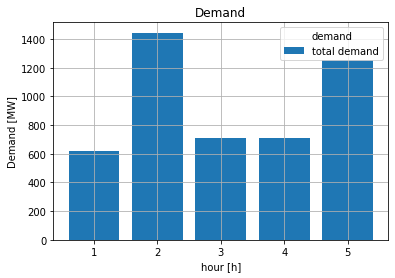

In [16]:
plt.bar(hour,demand,label='total demand')
#plt.bar(hour,suppren,label='residual demand')
plt.xlabel('hour [h]')
plt.ylabel('Demand [MW]')
plt.legend(title='demand')
plt.title('Demand')
plt.grid(True)
plt.show()

#### Choose a solver

In [17]:
#choose a solver
solver=4                 # choose solver: 1) BruteForce  2) MonteCarlo  3) MonteCarlo Gradient Descent 4) Simulated Annealing 5) Quantum Annealing  6) Azure Parallel Tempering  7) Azure Quantum Monte Carlo  8) Azure Stochastic Quantum Monte Carlo

#DWtoken='DEV-XXXXXXX'               # when using a quantum annealer, enter the access-token here

Num   =1000             # number of output solution - number of samples  (default should be 10,000)
rounds=1                 # number of ADDITIONAL rounds in which previous output states are used as initial states for the next solver run

#### Setting penalty strength, resolution, and feasibility filter



In [18]:
# penalty strengths; if all parameters are set to 0, the strength is set automatically
A = 0                         # cost penalty strength
B = 0                         # demand penalty strength
C = 0                         # minup penalty strength
C2= 0                         # mindown penalty strength
D = 0                         # on/off <-> start interrelation penalty strength
E = 0                         # power stages <-> on/off interrelation penalty strength
F=0
G=0
H=0

pres = 10                     # power resolution for discretization of power supply range of units

boolcheck=True                #choose "True" to only consider feasible solutions in the bestobjective-list

#### Display diagrams and other graphical outputs?



Set "graphicsout" to "True" if graphical output should be displayed. It is suppressed otherwise.



In [19]:
graphicsout= True    # show plots

#### Main Routine: run for solving the UCP

The solving algorithm always returns two types of "best" solutions: The first one always represents the solution with the lowest costs, the second one is the solution with the lowest objective function value. Depending on whether the **boolcheck**\-variable is set to "true" or not, the solutions are pre\-filtered to only contain feasible solution which fulfill all constraints or are allowed to violate constraints.


expectation value of demand:  [618.0, 1445.0, 710.0, 710.0, 1255.0]
expectation values of renewable supply:  [150.0, 200.0, 150.0, 170.0, 200.0]
expected eff. demand:  [468.00000000000017, 1244.9999999999995, 559.9999999999999, 540.0, 1055.0]
Start building relaxed UCP QUBO
time to build QUBO: 0.03766200000000097
Precision = 10
QUBO size:  165


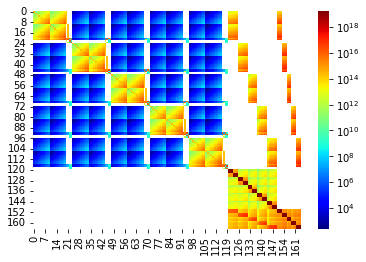

Starting solver engine
Start solver engine: Simulated annealing
1 rounds and  1000 iterations
#nonzeros/#quboEntries 13983 / 27225
sparsity 0.4863911845730028
time to find 1000 low energy output states with 1 subsequent runs of simulated annealing:  3.662285999999998


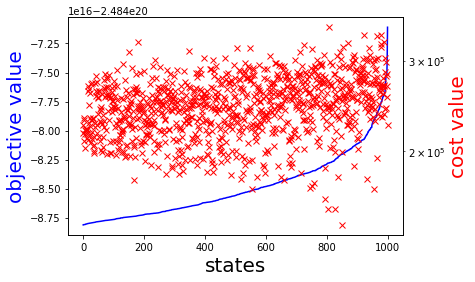

Time to solve (wall time):  3.662285999999998
lowest costs solution :
60.0	120.0	136.6715542521994 	401.22189638318673
30.0	150.0	242.56598240469208	722.0918866080156 
25.0	80.0 	34.0              	575.3176930596285 
35.0	80.0 	34.0              	575.3176930596285 
10.0	200.0	136.6715542521994 	453.32355816226783
best objective solution: 
50.0	80.0 	52.87683284457478 	335.14173998044964
30.0	120.0	499.0146627565982 	495.89442815249265
25.0	125.0	128.84457478005865	431.08504398826983
5.0 	135.0	402.3284457478006 	577.8592375366569 
90.0	200.0	151.8651026392962 	819.3059628543499 
Total costs of lowest costs solution:  176135.90909090906
Total costs of lowest objective solution:  216752.5855327468
Objective value of lowest costs solution:  -2.484873984287014e+20
Objective value of lowest objective solution:  -2.4848812739468362e+20
Acculumated absolute demand mismatch for lowest cost solution:  873.8758553274683
Acculumated absolute demand mismatch for objective solution:  816.5014662756

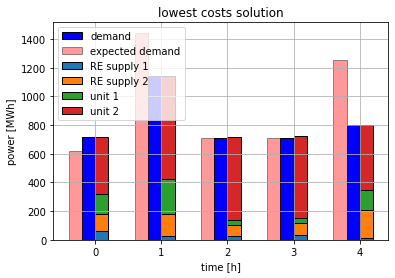

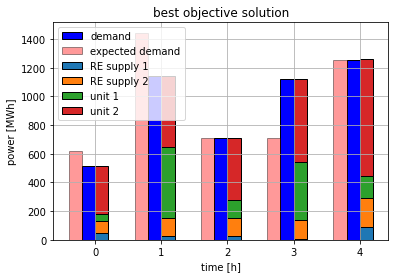

In [20]:
#set display size in diagrams
matplotlib.rcParams.update({'font.size': 10})

#initializing variables & setting variables with parameters / units

T=len(demand)                          # number of time steps
n = len(minup)                         # number of conventional power units
ppart = 1 / ((2**(pres) - 1))          # step size of logarithmic resolution

dgen0=[maxgen[i]-mingen[i] for i in range(len(mingen))]                     #power supply range of individual units



Clist = [dgen0[i]*varcost[i] for i in range(n)]                              #defining auxiliary variable for cost of unit i per timestep

dgen=[[ppart*dgen0[i]* 2**r for r in range(pres)] for i in range(n)]         #preparing power stage resolved "dgen"-vector

d=[]                                                                         #computing effective demans
for k in range(len(demand)):
    if len(suppren)!=0:
        if len(suppren)!=len(demand):
            print('Mismatch of timesteps in demand and suppren')
        d.append(demand[k] - np.sum(suppren[k]))
    else:
        d.append(demand[k])


#calculating expectation values
expD=[ sum(pdD[t][l]*probsD[t][l] for l in range(len(pdD[t]))) for t in range(T)]
if graphicsout==True:
    print('expectation value of demand: ', expD)
expRE=[ sum(sum(pdRE[t][j][s]*probsRE[t][j][s] for s in range(len(pdRE[t][j]))) for j in range(len(pdRE[t]))) for t in range(T)]
if graphicsout==True:
    print('expectation values of renewable supply: ', expRE)

from math import prod
comb=[list(itertools.product(*pdRE[i])) for i in range(len(pdRE))]
allcombinds_pdRE=[[[pdRE[l][list(np.array(m)).index(k)].index(k) for k in m] for m in comb[l]]for l in range(len(comb))]
allcombs_pdRE=[[[pdRE[l][m][allcombinds_pdRE[l][j][m]] for m in range(len(allcombinds_pdRE[l][j]))] for j in range(len(allcombinds_pdRE[l]))] for l in range(len(allcombinds_pdRE))]
expd=[sum(np.prod([probsRE[t][allcombinds_pdRE[t][m].index(allcombinds_pdRE[t][m][n])][allcombinds_pdRE[t][m][n]] for n in range(len(allcombs_pdRE[t][m]))])*probsD[t][r]*(pdD[t][r]-(sum(allcombs_pdRE[t][m][n] for n in range(len(allcombs_pdRE[t][m]))))) for m in range(len(allcombs_pdRE[t])) for r in range(len(pdD[t]))) for t in range(T)]
if graphicsout==True:
    print('expected eff. demand: ', expd)



if A==0 and B==0 and C==0 and C2==0 and D==0 and E==0 and F==0 and G==0 and H==0:                                                                 # set penalty strengths before passing to buildQUBO
    autoset=[1,0,0,0,0,0,0,0,0,0]
else:
    autoset=[0,A,B,C,C2,D,E,F,G,H]

Q, Qcost=buildSUCPqubo(autoset,n,pres,T,d,dgen,Clist,varcost,startcost,minup,mindown,mingen,maxgen,pdRE,pdD,expd)     # build QUBO
print("Precision =",pres)
print('QUBO size: ', len(Q))
if graphicsout==True:
    #print('QUBO size: ', len(Q))
    ax = sns.heatmap(abs(Q),  cmap="jet", norm=LogNorm())                                                   # plot QUBO heatmap
    plt.show()

print("Starting solver engine")

bestprice=float('inf')                                                                                   # initializing variables
bestobjectiveprice=float('inf')
bestobjective=float('inf')
bestobjectiveAns=np.zeros(len(Q))
bestpriceAns=np.zeros(len(Q))
bestpriceobj=float('inf')
bop1=float('inf')
bop2=float('inf')
bop3=float('inf')
bop4=float('inf')


#solve the problem with the chosen solver
if solver==1:
    price, Ans, combi, pricequality, objectivequality, qerrors,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, timetosolve= BruteForceUCPqubo(Q,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres, bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck,graphicsout)
if solver==2:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestpriceobj, bestobjectiveprice, bestobjectiveAns, bestobjective, timetosolve= MonteCarloUCPqubo(Q,Num,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres, bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck,graphicsout)
if solver==3:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestpriceobj, bestobjectiveprice, bestobjectiveAns, bestobjective, timetosolve= MCsteepestdescentUCPqubo(Q,Num,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck,graphicsout)
if solver==4:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestpriceobj, bestobjectiveprice, bestobjectiveAns, bestobjective, timetosolve =SimulatedAnnealingUCPqubo(Q,Num,rounds,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck, Qcost,graphicsout)
if solver==5:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestpriceobj, bestobjectiveprice, bestobjectiveAns, bestobjective, timetosolve=QuantumAnnealingUCPqubo(Q,Num,rounds,DWtoken,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck, Qcost,graphicsout)
if solver==6:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, timetosolve = AzureRoutinePT(workspace,Q,Num,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck, Qcost, graphicsout)
if solver==7:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, timetosolve = AzureRoutineQMC(workspace,Q,Num,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck, Qcost, graphicsout)
if solver==8:
    price, Ans, combi, qerrors, bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, timetosolve = AzureRoutineSQMC(workspace,Q,Num,dgen,varcost,startcost,mingen,minup,mindown,T,n,pres,bestprice, bestpriceAns, bestobjective, bestobjectiveAns, bestobjectiveprice, bestpriceobj, boolcheck, Qcost, graphicsout)


# post-processing of result
REres=len(pdRE[0][0])
Dres=len(pdD[0])
lREnum=len(pdRE[0])
lREt=len(pdRE[0])*len(pdRE[0][0])
lRE=T*lREnum*REres
lD =T*Dres

dim=n*(pres+2)*T     #dimension of QUBO (size) without stochastic part
dimt=n*(pres+2)      #size of one time step

bestobjectiveAns=Ans
pDemand=[sum(bestpriceAns[n*(pres+2)*T+T*lREnum*REres+t*Dres+Y]*pdD[t][Y] for Y in range(Dres)) for t in range(T)]
oDemand=[sum(bestobjectiveAns[n*(pres+2)*T+lRE+t*Dres+l]*pdD[t][l] for l in range(len(pdD[0]))) for t in range(T)]




pp = np.zeros((T, n+len(pdRE[0])))
pp2 = np.zeros((T, n))
psupply1=np.zeros((T, n+len(pdRE[0])))
psupply2=np.zeros((T, n+len(pdRE[0])))
ppower=np.zeros((T,n,pres))
pstart=np.zeros((T,n))
pon=np.zeros((T,n))

op = np.zeros((T, n+len(pdRE[0])))
op2 = np.zeros((T, n))
osupply1=np.zeros((T, n+len(pdRE[0])))
osupply2=np.zeros((T, n+len(pdRE[0])))
opower=np.zeros((T,n,pres))
ostart=np.zeros((T,n))
oon=np.zeros((T,n))
pREstages=np.zeros((T,len(pdRE[0])))
oREstages=np.zeros((T,len(pdRE[0])))
pDstages=np.zeros(T)
oDstages=np.zeros(T)


time=[]
for t in range(T):
    time.append(t + 1)
    for i in range(n):
        for r in range(pres):
            pp2[t][i] = pp2[t][i] + bestpriceAns[t*n*(pres+2)+i*pres+r]+bestpriceAns[t*n*(pres+2)+n*pres+i]
            op2[t][i] = op2[t][i] + bestobjectiveAns[t*n*(pres+2)+i*pres+r]+bestobjectiveAns[t*n*(pres+2)+n*pres+i]




for t in range(T):
    for l in range(len(pdD[0])):
        pDstages[t]=pDstages[t] + bestpriceAns[n*(pres+2)*T+lRE+t*Dres+l]
        oDstages[t]=oDstages[t] + bestobjectiveAns[n*(pres+2)*T+lRE+t*Dres+l]
    for i in range(n+len(pdRE[0])):
        if i < len(pdRE[0]):
            for s in range(REres):
                pp[t][i] = pp[t][i] + bestpriceAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                op[t][i] = op[t][i] + bestobjectiveAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                psupply1[t][i]=psupply1[t][i] + bestpriceAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                osupply1[t][i]=osupply1[t][i] + bestobjectiveAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                psupply2[t][i]=psupply2[t][i] + bestpriceAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                osupply2[t][i]=osupply2[t][i] + bestobjectiveAns[n*(pres+2)*T+t*lREt+i*REres+s]*pdRE[t][i][s]
                pREstages[t][i]=pREstages[t][i] + bestpriceAns[n*(pres+2)*T+t*lREt+i*REres+s]
                oREstages[t][i]=oREstages[t][i] + bestobjectiveAns[n*(pres+2)*T+t*lREt+i*REres+s]
        else:
            for r in range(pres):
                pp[t][i] = pp[t][i] + bestpriceAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
                op[t][i] = op[t][i] + bestobjectiveAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
            if pp2[t][i-len(pdRE[0])]>0:
                pp[t][i] = pp[t][i] + mingen[i-len(pdRE[0])]
            if op2[t][i-len(pdRE[0])]>0:
                op[t][i] = op[t][i] + mingen[i-len(pdRE[0])]
            pon[t][i-len(pdRE[0])]=bestpriceAns[t*n*(pres+2)+n*(pres)+i-len(pdRE[0])]
            oon[t][i-len(pdRE[0])]=bestobjectiveAns[t*n*(pres+2)+n*(pres)+i-len(pdRE[0])]
            pstart[t][i-len(pdRE[0])]=bestpriceAns[t*n*(pres+2)+n*(pres+1)+i-len(pdRE[0])]
            ostart[t][i-len(pdRE[0])]=bestobjectiveAns[t*n*(pres+2)+n*(pres+1)+i-len(pdRE[0])]
            if pp2[t][i-len(pdRE[0])]>0:
                for r in range(pres):
                    ppower[t][i-len(pdRE[0])][r]=bestpriceAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]
                    psupply1[t][i]=psupply1[t][i]+bestpriceAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
                    psupply2[t][i]=psupply2[t][i]+bestpriceAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
                psupply1[t][i]=psupply1[t][i]+mingen[i-len(pdRE[0])]
                psupply2[t][i]=psupply2[t][i]+mingen[i-len(pdRE[0])]*bestpriceAns[t*n*(pres+2)+n*(pres)+i-len(pdRE[0])]
            if op2[t][i-len(pdRE[0])]>0:
                for r in range(pres):
                    opower[t][i-len(pdRE[0])][r]=bestobjectiveAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]
                    osupply1[t][i]=osupply1[t][i]+bestobjectiveAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
                    osupply2[t][i]=osupply2[t][i]+bestobjectiveAns[t*n*(pres+2)+(i-len(pdRE[0]))*pres+r]*dgen[i-len(pdRE[0])][r]
                osupply1[t][i]=osupply1[t][i]+mingen[i-len(pdRE[0])]
                osupply2[t][i]=osupply2[t][i]+mingen[i-len(pdRE[0])]*bestobjectiveAns[t*n*(pres+2)+n*(pres)+i-len(pdRE[0])]

if graphicsout==True:
    print('lowest costs solution :')                                             # printing table of the lowest costs unit allocation
    s = [[str(e) for e in row] for row in psupply2]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))


    print('best objective solution: ')                                           # printing table of the lowest objective unit allocation
    s = [[str(e) for e in row] for row in osupply2]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))


print('Total costs of lowest costs solution: ', np.matmul(np.matmul(bestpriceAns,Qcost),np.transpose(bestpriceAns)))

if graphicsout==True:
    print('Total costs of lowest objective solution: ',np.matmul(np.matmul(bestobjectiveAns,Qcost),np.transpose(bestobjectiveAns)))
    print('Objective value of lowest costs solution: ', np.matmul(np.matmul(bestpriceAns,Q),np.transpose(bestpriceAns)))
    print('Objective value of lowest objective solution: ',np.matmul(np.matmul(bestobjectiveAns,Q),np.transpose(bestobjectiveAns)))

    
pdiff=[demand[t] for t in range(T)]
odiff=[demand[t] for t in range(T)]
for t in range(T):
    for i in range(len(psupply2[0])):
        pdiff[t]=pdiff[t]-psupply2[t][i]
        odiff[t]=odiff[t]-osupply2[t][i]
if graphicsout==True:
    print('Acculumated absolute demand mismatch for lowest cost solution: ', sum(np.fromiter((abs(pdiff[t]) for t in range(T)), float)))
    print('Acculumated absolute demand mismatch for objective solution: ', sum(np.fromiter((abs(odiff[t]) for t in range(T)), float)))


okay, pmincheck, oncheck, startcheck, minupcheck, mindowncheck, errorquality = penaltycheck(bestpriceAns,dgen,mingen,pstart,minup,mindown,pon,T,n,pres)
if graphicsout==True:
    print('All constraints fulfilled for lowest costs solution?: ', okay)
    print('pmincheck: ',pmincheck,'minupcheck: ',minupcheck,'mindowncheck: ',mindowncheck,'oncheck: ',oncheck,'startcheck: ',startcheck)

okay, pmincheck, oncheck, startcheck, minupcheck, mindowncheck, errorquality = penaltycheck(bestobjectiveAns,dgen,mingen,ostart,minup,mindown,oon,T,n,pres)
if graphicsout==True:
    print('All constraint fulfilled for best objective solution: ', okay)
    print('mingen fulfilled?: ',pmincheck)
    print('minup fulfilled?: ',minupcheck)
    print('mindown fulfilled?: ',mindowncheck)
    print('"on"-variable always set correctly?: ',oncheck)
    print('"start"-variable always set correctly?: ',startcheck)


if graphicsout==True:
    # plotting results
    width = 0.2

    plt.figure(2) # plottning best price - solution
    plt.bar([x - width / 2 for x in range(T)],
            pDemand,
            color='b',
            width=width,
            edgecolor='black',
            label='demand')
    plt.bar([x - 1.5*width  for x in range(T)],
            expD,
            color='r',
            width=width,
            alpha=0.4,
            edgecolor='black',
            label='expected demand')

    labels = ['RE supply '+str(i+1) for i in range(len(pdRE[0]))]
    for i in range(n):
        labels.append('unit '+str(i+1))
    for i in range(n + len(pdRE[0])):
        if i == 0:
            plt.bar(
                [x + width / 2 for x in range(T)],
                [y[0] for y in psupply2],
                width=width,
                edgecolor='black',
                label=labels[i],
                bottom=0)
        else:
            x = np.zeros(T)
            for k in range(i):
                x = np.add(x, [y[k] for y in psupply2])
            plt.bar(
                [x + width / 2 for x in range(T)],
                [y[i] for y in psupply2],
                width=width,
                edgecolor='black',
                label=labels[i],
                bottom=x)

    plt.xlabel("time [h]")
    plt.ylabel("power [MWh]")
    plt.title("lowest costs solution")
    plt.legend(loc=2)
    plt.grid()
    #plt.savefig('SimAnCost2.eps',dpi='figure')
    #plt.savefig('SimAnCost2.png')
    plt.show()

    plt.figure(3) # plottning best objective - solution
    plt.bar([x - width / 2 for x in range(T)],
            oDemand,
            color='b',
            width=width,
            edgecolor='black',
            label='demand')
    plt.bar([x - 1.5*width  for x in range(T)],
            expD,
            color='r',
            width=width,
            edgecolor='black',
            alpha=0.4,
            label='expected demand')

    labels = ['RE supply '+str(i+1) for i in range(len(pdRE[0]))]
    for i in range(n):
        labels.append('unit '+str(i+1))
    for i in range(n + len(pdRE[0])):
        if i == 0:
            plt.bar(
                [x + width / 2 for x in range(T)],
                [y[0] for y in osupply2],
                width=width,
                edgecolor='black',
                label=labels[i],
                bottom=0)
        else:
            x = np.zeros(T)
            for k in range(i):
                x = np.add(x, [y[k] for y in osupply2])
            plt.bar(
                [x + width / 2 for x in range(T)],
                [y[i] for y in osupply2],
                width=width,
                edgecolor='black',
                label=labels[i],
                bottom=x)

    plt.xlabel("time [h]")
    plt.ylabel("power [MWh]")
    plt.title("best objective solution")
    plt.legend(loc=2)
    plt.grid()
    #plt.savefig('SimAnObj2.eps',dpi='figure')    #
    #plt.savefig('SimAnObj2.png')
    plt.show()